<a href="https://colab.research.google.com/github/odunola25/MSC-project/blob/work/InceptionV3_Final_Batch_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_dir = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Training_project'
test_dir = '/content/drive/MyDrive/MSC Project/Brain Tumor MRI Dataset/Testing_project'

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle = False,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the pre-trained MobileNet model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

from tensorflow.keras import Model, Input

# Define the model
inputs = Input(shape=(224, 224, 3))
x = inception_base(inputs, training=False)  # Use 'training=False' to keep batch norm and dropout layers in inference mode
x = GlobalAveragePooling2D()(x) # Apply global average pooling to convert feature maps to a single vector
x = BatchNormalization()(x) # Normalize the output to improve training speed and stability
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x) # Add a dense layer with L2 regularization to avoid overfitting
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)

inception_model = Model(inputs, outputs)

# Print model summary
inception_model.summary()

# Fine-tune the MobileNet model
fine_tune_at_inception = 100
inception_base.trainable = True  # Make all layers trainable
for layer in inception_base.layers[:fine_tune_at_inception]:
    layer.trainable = False  # Freeze the layers up to fine_tune_at_mobilenet

# Compile the model
inception_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the summary of the model after compiling
#inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,913,252 (91.22 MB)

 Trainable params: 23,874,724 (91.07 MB)

 Non-trainable params: 38,528 (150.50 KB)

In [ ]:
# Set up callbacks for InceptionV3
early_stopping_inception = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
model_checkpoint_inception = ModelCheckpoint('content/drive/MyDrive/MSC Project/32_inception_fine_tuned_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr_inception = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Train the MobileNet model
history_inception = inception_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stopping_inception, model_checkpoint_inception, reduce_lr_inception],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4456 - loss: 2.8696
Epoch 1: val_loss improved from inf to 1.98581, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_inception_fine_tuned_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 1919s 10s/step - accuracy: 0.4463 - loss: 2.8676 - val_accuracy: 0.7712 - val_loss: 1.9858 - learning_rate: 1.0000e-05
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.7506 - loss: 2.0515
Epoch 2: val_loss improved from 1.98581 to 1.82857, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_inception_fine_tuned_model.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 160s 585ms/step - accuracy: 0.7507 - loss: 2.0512 - val_accuracy: 0.8261 - val_loss: 1.8286 - learning_rate: 1.0000e-05
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.8059 - loss: 1.9132
Epoch 3: val_loss improved from 1.82857 to 1.76191, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/32_inception_fine

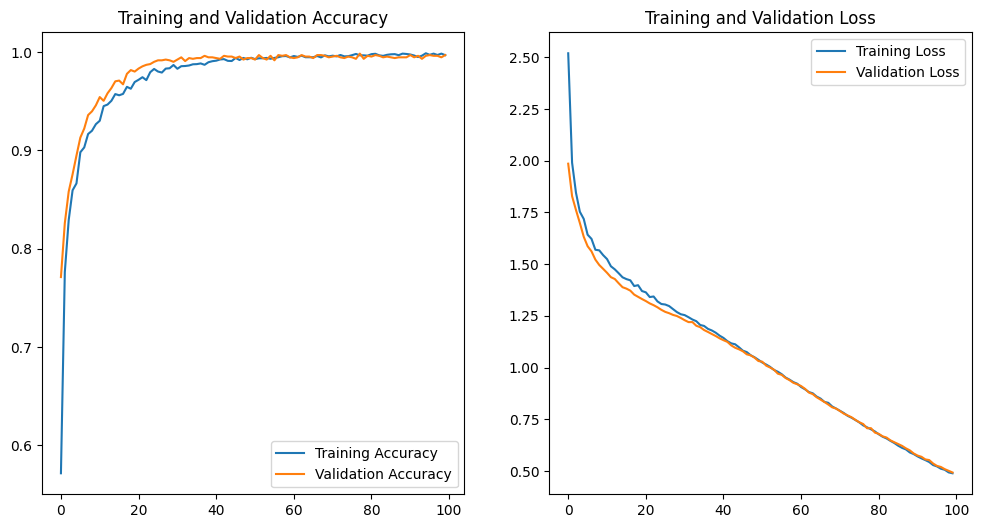

In [ ]:
# Plot the training and validation accuracy and loss curves
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Load the best model
best_model_path = '/content/drive/MyDrive/MSC Project/32_inception_fine_tuned_model.keras'

inception_model_32 = tf.keras.models.load_model(best_model_path)

In [ ]:
# Evaluate the best model
test_loss, test_accuracy = inception_model_32.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.9964 - loss: 0.5008
Test Accuracy: 0.9969488978385925


In [ ]:
import os
import glob

def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [ ]:
testing_images = get_number(test_dir)

print("Number of testing samples is", testing_images)

Number of testing samples is 1311


In [ ]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = inception_model_32.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 278ms/step
[0 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      Glioma       1.00      0.99      1.00       300
  Meningioma       0.99      1.00      1.00       306
   No Tumour       1.00      1.00      1.00       405
   Pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



In [ ]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 1311
Number of correct predictions 1307
Number of incorrect predictions 4


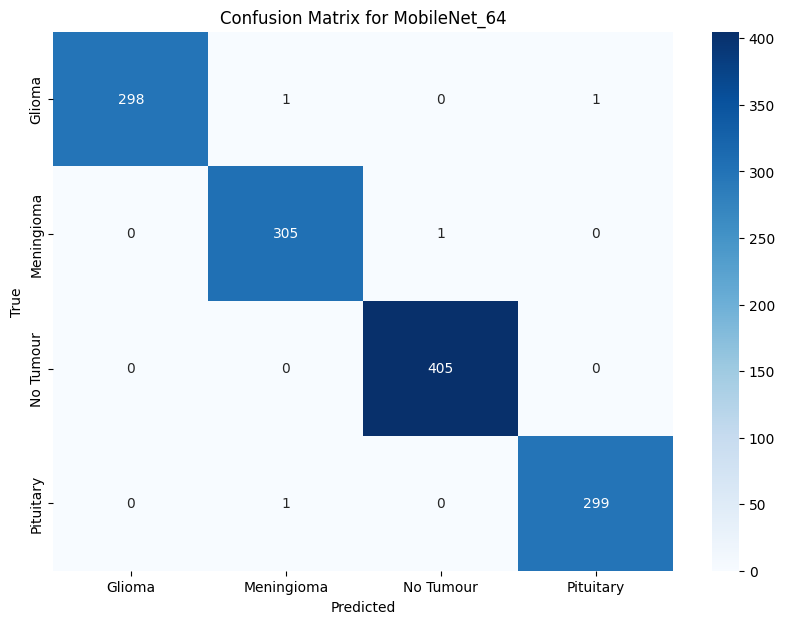

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Classes, yticklabels=Classes)
plt.title('Confusion Matrix for MobileNet_64')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()